In [3]:
from tensorflow.keras import models, optimizers, callbacks
#import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=300
import time
from network_functions import *
from data_generation_functions import generate_final_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_1 = np.load("training/data/1OverF_1.npz")
data_2 = np.load("training/data/Lor_1.npz")
data_3 = np.load("training/data/1OverF-Lorf_1.npz")
c_data = np.append( data_1['arr_0'], np.append( data_2['arr_0'], data_3['arr_0'], axis=0 ), axis=0 )
T_in = data_1['arr_1']         # Time vector for data generation 
s_data = np.append( data_1['arr_2'], np.append( data_2['arr_2'], data_3['arr_2'], axis=0 ), axis=0 )
w0 = data_1['arr_3']           # Omega vector for data generation
T_train = data_1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data_1['arr_5']      # Omega vector for training data
T2_span = data_1['arr_6']      # T2 distribution

In [5]:
x_train1, x_test1, y_train1, y_test1 = \
generate_final_data(c_data,T_in,s_data,w0,T_train,w_train,T2_span, test_size=0.15)

print("x_train1 = ",np.shape(x_train1))
print("y_train1 = ",np.shape(y_train1))
print("x_test1 = ",np.shape(x_test1))
print("y_test1 = ",np.shape(y_test1))
x_train_size = np.shape(x_train1)[-1]

x_train1 =  (85812, 147)
y_train1 =  (85812, 501)
x_test1 =  (15144, 147)
y_test1 =  (15144, 501)


In [6]:
BATCH_SIZE = 64
EPOCHS = 20
INIT_LR = 1e-5
MAX_LR = 1e-3

model = get_model( filter_nb=80, kernel_size=48, pool_size=2, dropout_rate=0.05, xtrain_size=x_train_size )
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 80)           3920      
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 80)           307280    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 74, 40)            153640    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)        

2023-07-08 18:22:24.905480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-08 18:22:24.905561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## SINGLE MODEL TRAINING

In [7]:
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 1000

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=8,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)
model = get_model( filter_nb=80, kernel_size=42, pool_size=2, dropout_rate=0.05 )
opt = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt)
history_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

model.save('training/CNN_fil=80_REDUCE_minLR=1e-6_3_TYPES', overwrite=True)

TypeError: get_model() missing 1 required positional argument: 'xtrain_size'

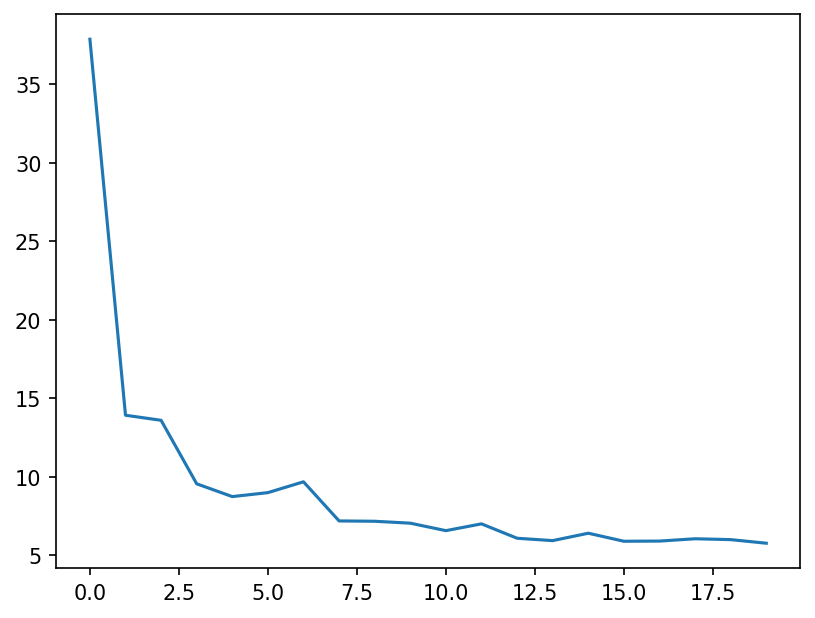

In [8]:
#tot_history = history_.history['val_loss'] 
tot_history = np.append( history1_.history['val_loss'],history2_.history['val_loss'] )
tot_history = np.append( tot_history,history3_.history['val_loss'] )
tot_history = np.append( tot_history,history4_.history['val_loss'] )
tot_history = np.append( tot_history,history5_.history['val_loss'] )

#epochs = np.arange( 0, EPOCHS )
epochs = np.arange( 0, EPOCHS1+EPOCHS2+EPOCHS3+EPOCHS4+EPOCHS5 )

plt.plot( epochs, tot_history )
plt.show()


##  MODEL TESTING

In [8]:
reconstructed_model = models.load_model( "training/CNN_fil=80_REDUCE_minLR=1e-6_3_TYPES", compile=False )

In [9]:
probability_model = tf.keras.Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

  8/474 [..............................] - ETA: 3s  

2023-07-08 16:58:14.300646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


474/474 [==============================] - 4s 8ms/step


(0.0, 500000.0)

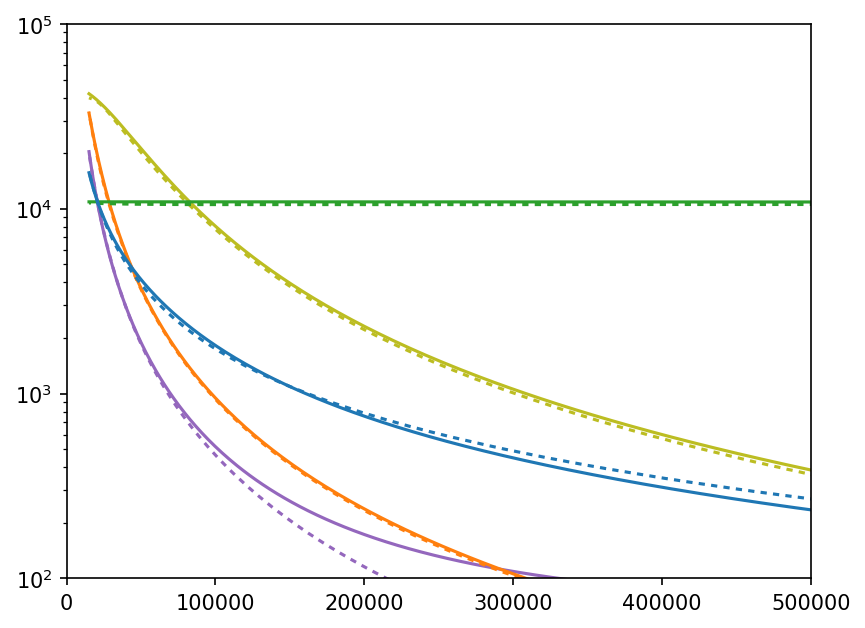

In [12]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

NameError: name 'y_test' is not defined

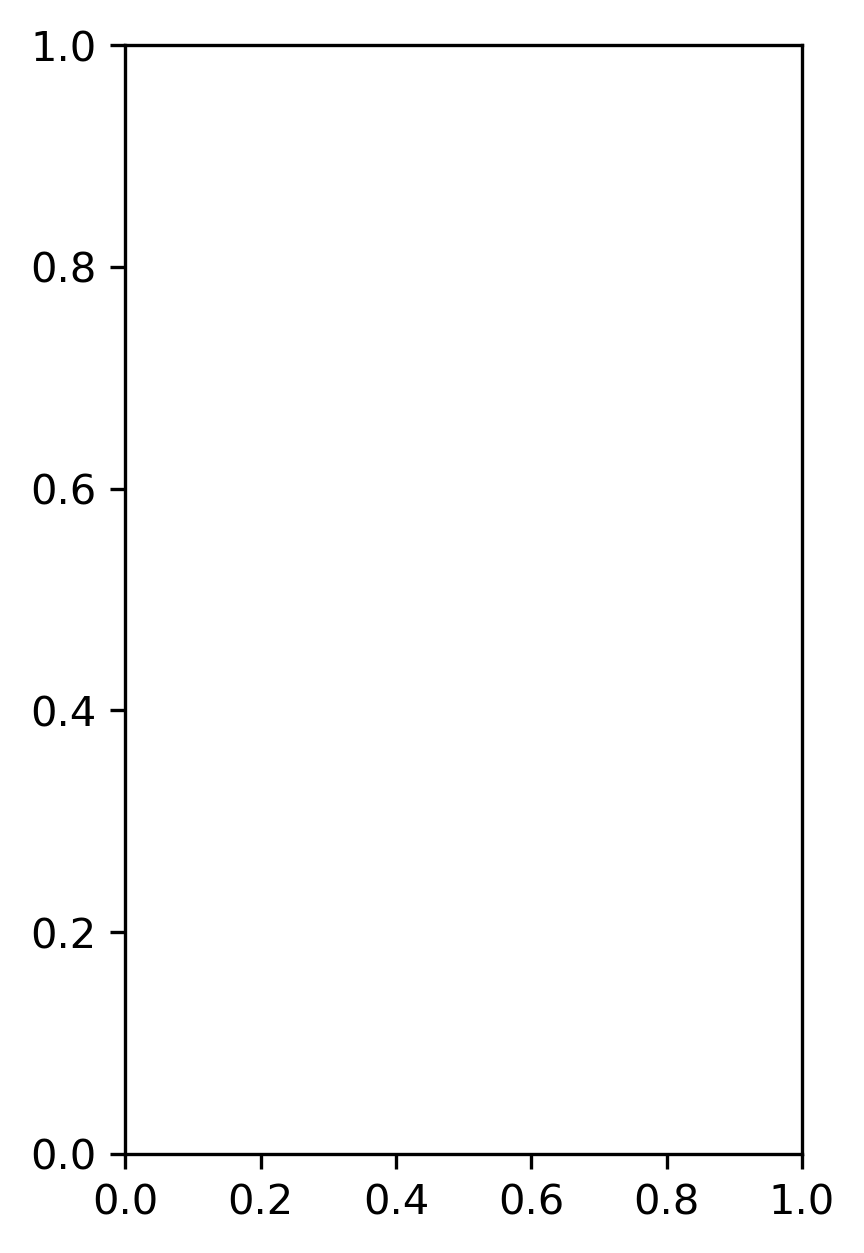

In [2]:
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))